In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
col_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('AEP_hourly.csv')

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df =  pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


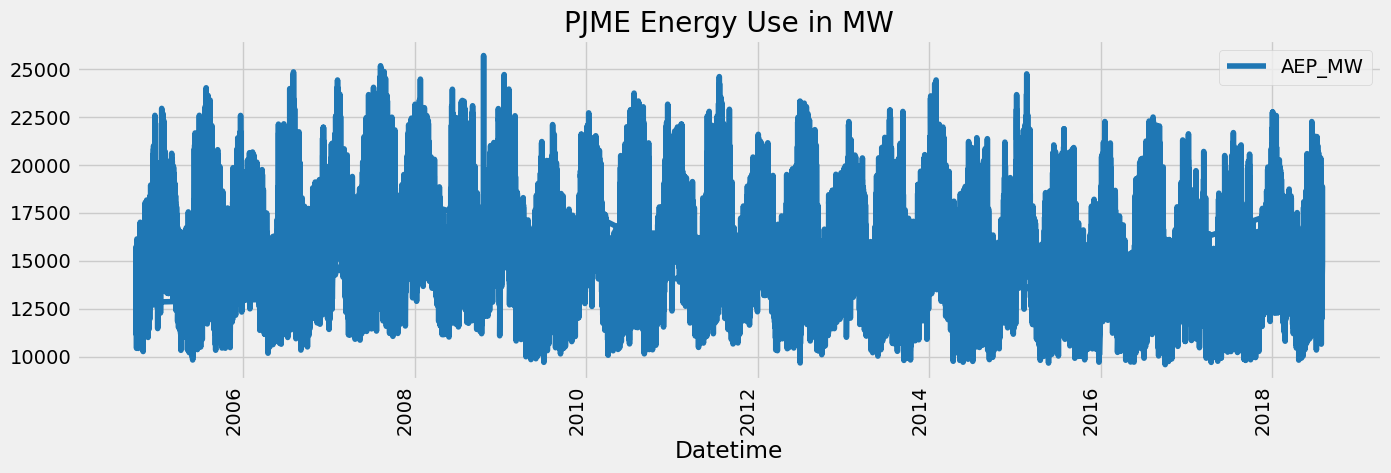

In [6]:
df.plot(style='-', figsize=(15,5),color=col_pal[0], title='PJME Energy Use in MW')
plt.xticks(rotation=90)
plt.show();

# OUTLIER DETECTION

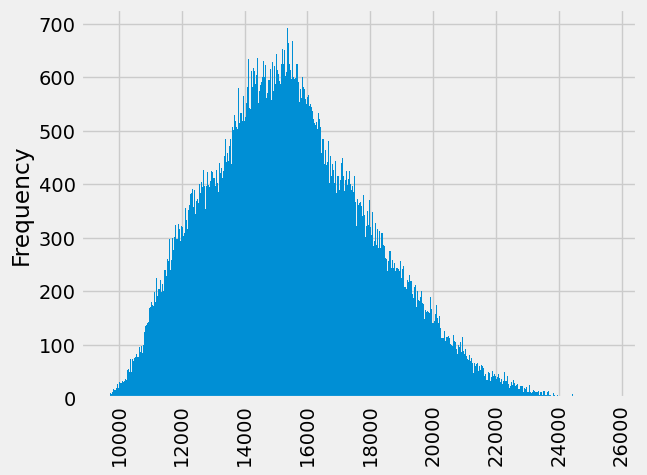

In [8]:
df['AEP_MW'].plot(kind = 'hist', bins = 500)
plt.xticks(rotation=90);

<Axes: xlabel='Datetime'>

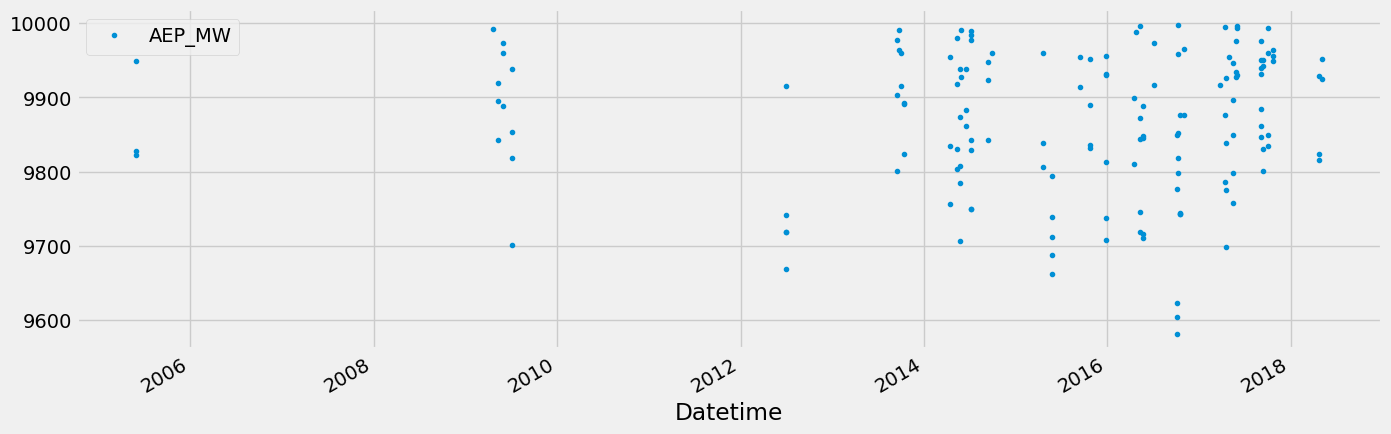

In [9]:
df.query('AEP_MW < 10000').plot(figsize=(15,5), style='.')

In [10]:
train = df.loc[df.index < '01-01-2015'] #We train all data sets from 2015 to 2018
test  =  df.loc[df.index >= '01-01-2015'] #Test dataset of 2004 to 2015

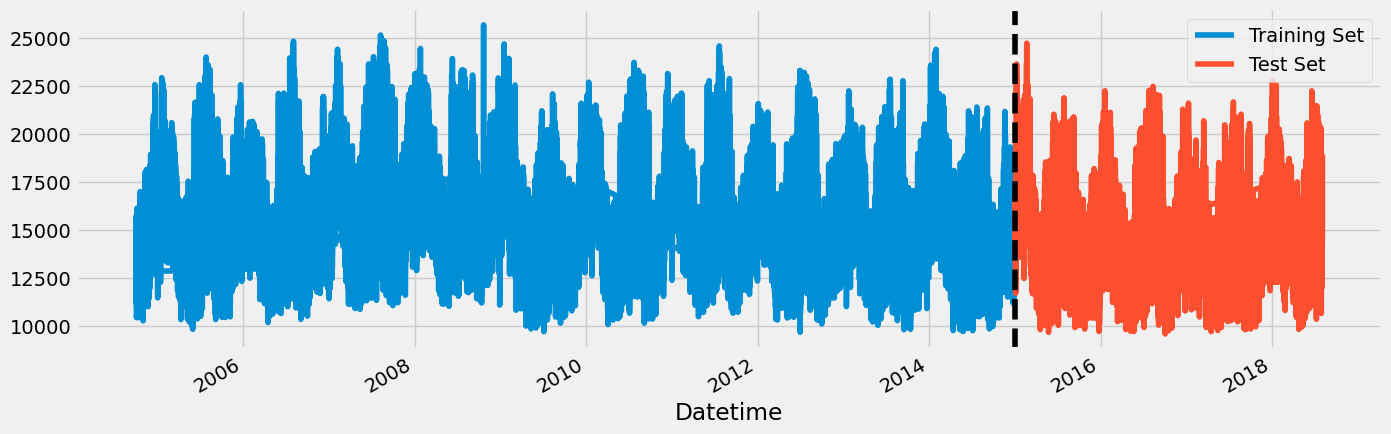

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label= 'Training Set')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

## TIME SERIES CROSS VALIDATION

In [13]:
from sklearn.model_selection import TimeSeriesSplit

In [14]:
help(TimeSeriesSplit)

Help on class TimeSeriesSplit in module sklearn.model_selection._split:

class TimeSeriesSplit(_BaseKFold)
 |  TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0)
 |
 |  Time Series cross-validator.
 |
 |  Provides train/test indices to split time series data samples
 |  that are observed at fixed time intervals, in train/test sets.
 |  In each split, test indices must be higher than before, and thus shuffling
 |  in cross validator is inappropriate.
 |
 |  This cross-validation object is a variation of :class:`KFold`.
 |  In the kth split, it returns first k folds as train set and the
 |  (k+1)th fold as test set.
 |
 |  Note that unlike standard cross-validation methods, successive
 |  training sets are supersets of those that come before them.
 |
 |  Read more in the :ref:`User Guide <time_series_split>`.
 |
 |  For visualisation of cross-validation behaviour and
 |  comparison between common scikit-learn split methods
 |  refer to :ref:`sphx_glr_auto_examples

In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [16]:
df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


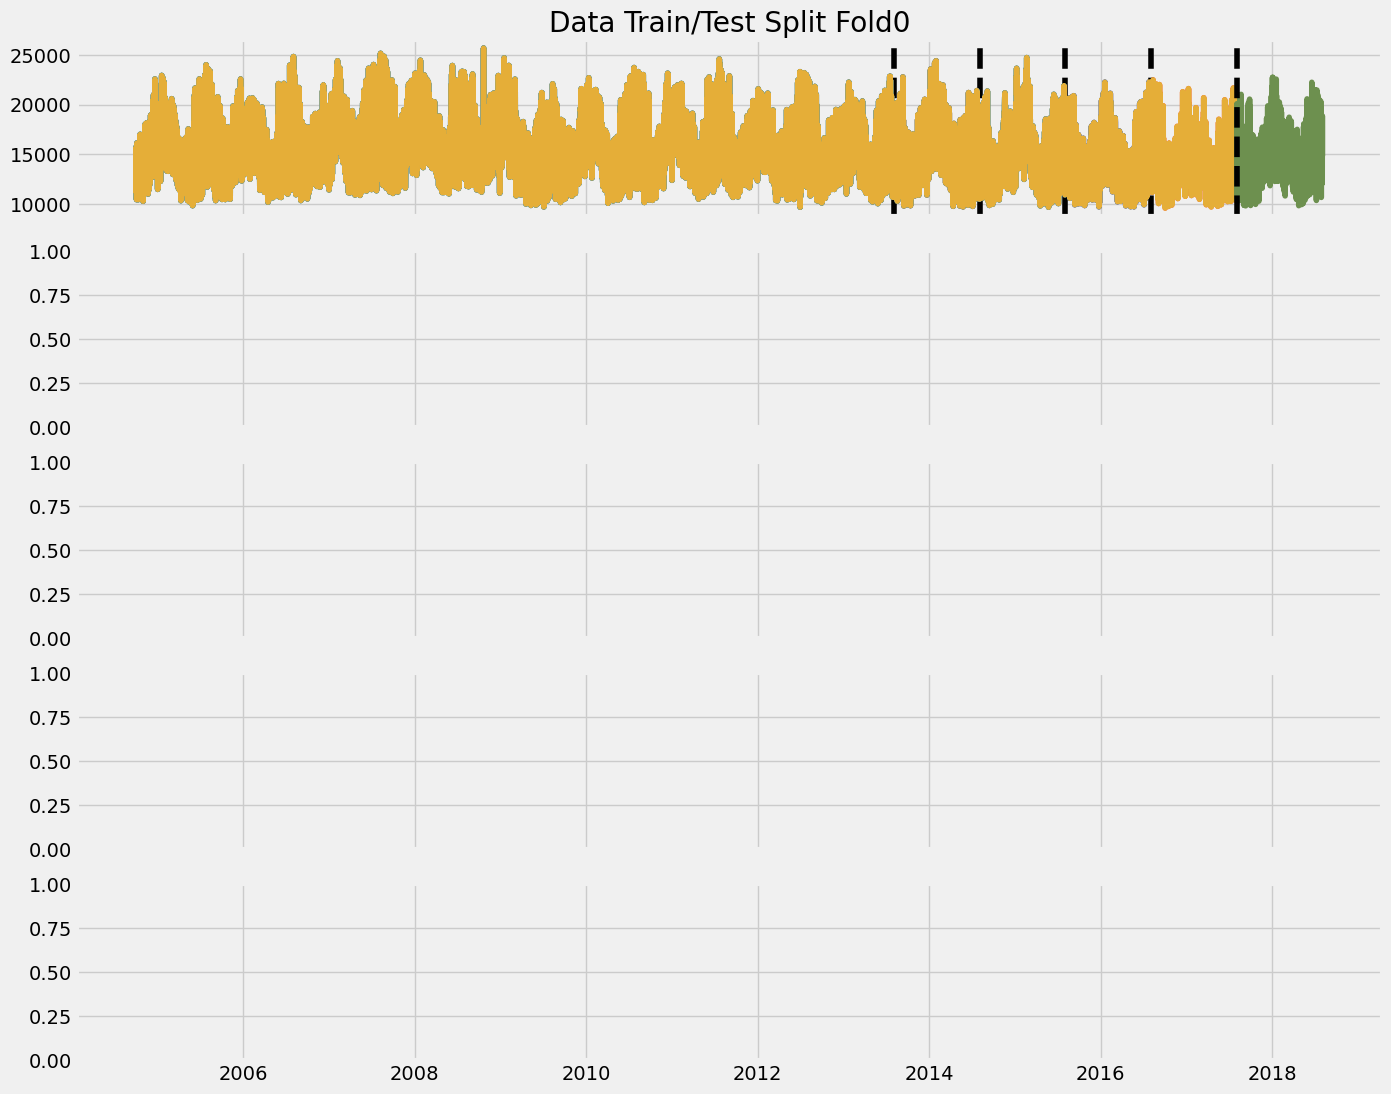

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15),
                            sharex=True)

fold= 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Test Split Fold{fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                       label='Test set')
    axs[fold].axvline(test.index.min(), color='black',ls='--')
    fold == 1
plt.show()

# FORECASTING HORIZONS

The forecasting horizon is the length of time into the futute for which forescasts are to be prepared. These generally vary from short term forecastin (two to three months)
and long term (more than two to three years)

In [20]:
def create_features(df):
    '''
    create time series based on time series index
    '''
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

    df = create_features(df)

In [21]:
df = create_features(df)

## LAG FEATURES

#### What was the target (x) days in the past

In [24]:
df.head(2)

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275


In [25]:
target_map = df['AEP_MW'].to_dict()

In [26]:
def add_lags(df):
    df['lag 1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag 2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag 3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [27]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275


In [28]:
df = add_lags(df)

In [29]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag 1,lag 2,lag 3
Datetime,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN


In [116]:
df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag 1,lag 2,lag 3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18705.0,20140.0,16078.0
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18108.0,19616.0,15908.0
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17544.0,19246.0,15783.0
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,16262.0,17943.0,14808.0
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,15045.0,16491.0,13669.0


In [118]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'lag 1', 'lag 2', 'lag 3'],
      dtype='object')

In [120]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold= 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag 1', 'lag 2', 'lag 3']
    target = ['AEP_MW']

    X_train = train[FEATURES]
    y_train = train[target]

    X_test = test[FEATURES]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster= 'gbtree',
                           n_estimators = 1000, early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:15898.36633	validation_1-rmse:15264.18323


C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:00] WARNING: D:\bld\xgboost-split_1727635034975\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6031.31414	validation_1-rmse:5645.48061
[200]	validation_0-rmse:2654.73567	validation_1-rmse:2429.72487
[300]	validation_0-rmse:1710.33127	validation_1-rmse:1647.64977
[400]	validation_0-rmse:1491.06346	validation_1-rmse:1554.16784
[464]	validation_0-rmse:1447.06260	validation_1-rmse:1556.92999
[0]	validation_0-rmse:15835.43959	validation_1-rmse:15221.95383


C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:05] WARNING: D:\bld\xgboost-split_1727635034975\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6007.78651	validation_1-rmse:5715.31503
[200]	validation_0-rmse:2646.11681	validation_1-rmse:2506.80517
[300]	validation_0-rmse:1708.44615	validation_1-rmse:1615.82625
[400]	validation_0-rmse:1501.68843	validation_1-rmse:1454.25308
[500]	validation_0-rmse:1443.65105	validation_1-rmse:1429.72652
[600]	validation_0-rmse:1412.01741	validation_1-rmse:1426.01093
[643]	validation_0-rmse:1402.82849	validation_1-rmse:1425.74479
[0]	validation_0-rmse:15779.22847	validation_1-rmse:14549.82659


C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:11] WARNING: D:\bld\xgboost-split_1727635034975\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5985.45144	validation_1-rmse:5101.01209
[200]	validation_0-rmse:2635.24412	validation_1-rmse:2053.30046
[300]	validation_0-rmse:1704.00737	validation_1-rmse:1507.70024
[375]	validation_0-rmse:1527.09283	validation_1-rmse:1521.24493
[0]	validation_0-rmse:15679.42424	validation_1-rmse:14632.67713


C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:16] WARNING: D:\bld\xgboost-split_1727635034975\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5950.53232	validation_1-rmse:5462.18027
[200]	validation_0-rmse:2627.60827	validation_1-rmse:2469.11499
[300]	validation_0-rmse:1707.92103	validation_1-rmse:1780.20853
[400]	validation_0-rmse:1505.81318	validation_1-rmse:1667.98889
[500]	validation_0-rmse:1445.78101	validation_1-rmse:1657.60437
[600]	validation_0-rmse:1418.47695	validation_1-rmse:1651.54869
[700]	validation_0-rmse:1399.43030	validation_1-rmse:1648.88357
[729]	validation_0-rmse:1395.59194	validation_1-rmse:1649.59392
[0]	validation_0-rmse:15600.77032	validation_1-rmse:15012.58652


C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:24] WARNING: D:\bld\xgboost-split_1727635034975\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5924.87627	validation_1-rmse:5860.41470
[200]	validation_0-rmse:2626.42406	validation_1-rmse:2776.89747
[300]	validation_0-rmse:1717.89176	validation_1-rmse:1901.73680
[400]	validation_0-rmse:1515.18892	validation_1-rmse:1714.38709
[500]	validation_0-rmse:1458.08436	validation_1-rmse:1700.32649
[522]	validation_0-rmse:1450.61482	validation_1-rmse:1703.46147


### CROSS VALIDATION SCORES

In [122]:
scores

[1553.1311553484215,
 1425.550391708293,
 1498.585481390156,
 1647.9270157786607,
 1697.7629177644824]

In [125]:
print(f'Score across folds {np.mean(scores):0.4}')
print(f'Fold scores:{scores}')

Score across folds 1.565e+03
Fold scores:[1553.1311553484215, 1425.550391708293, 1498.585481390156, 1647.9270157786607, 1697.7629177644824]


## PREDICTING THE FUTURE

Retraining on all the data


To predict the future we need an empty dataframe for future data ranges


Run those dates through our feature creatin code + lag creation

In [134]:

    df = create_features(df)                                                                                                                                
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag 1', 'lag 2', 'lag 3']
    target = ['AEP_MW']

    X_all = train[FEATURES]
    y_all = train[target]


    reg = xgb.XGBRegressor(base_score=0.5, booster= 'gbtree',
                           n_estimators = 500,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
    verbose=100)

[0]	validation_0-rmse:15600.77032


C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:26] WARNING: D:\bld\xgboost-split_1727635034975\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5924.87627
[200]	validation_0-rmse:2626.42406
[300]	validation_0-rmse:1717.89176
[400]	validation_0-rmse:1515.18892
[499]	validation_0-rmse:1458.30034


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [136]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [138]:
df.index.min()

Timestamp('2004-10-01 01:00:00')

In [144]:
#Create Future Data Frame
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')# Hourly prediction
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [146]:
df_and_future

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag 1,lag 2,lag 3,isFuture
2004-10-01 01:00:00,12379.0,1.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,False
2004-10-01 02:00:00,11935.0,2.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,False
2004-10-01 03:00:00,11692.0,3.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,False
2004-10-01 04:00:00,11597.0,4.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,False
2004-10-01 05:00:00,11681.0,5.0,4.0,4.0,10.0,2004.0,275.0,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [150]:
#Create Future Data Frame
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')# Hourly prediction
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [152]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the Future

In [155]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

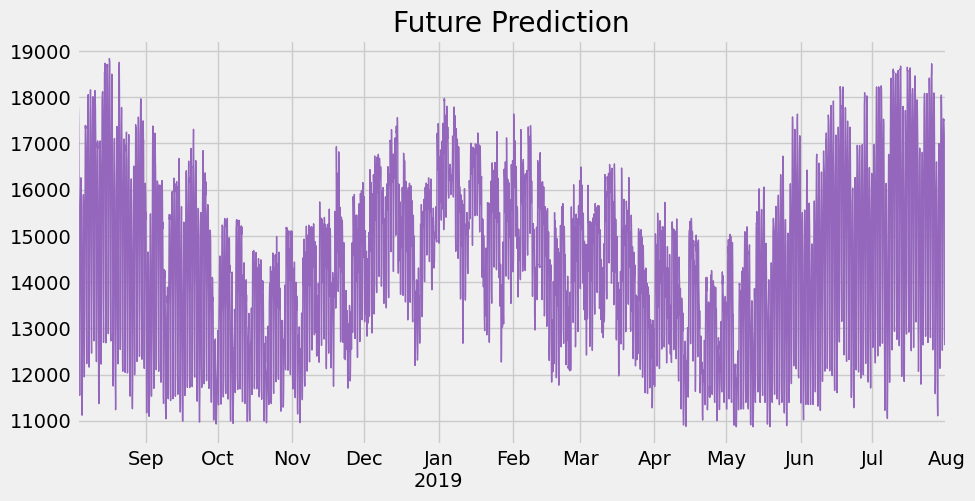

In [159]:
future_w_features['pred'].plot(figsize=(10, 5),
                              color=col_pal[4],
                              ms=1,
                              lw=1,
                              title='Future Prediction')
plt.show()

## SAVING MODEL FOR THE FUTURE USE

In [162]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [164]:
reg.save_model('model.jsom')

C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:36] WARNING: D:\bld\xgboost-split_1727635034975\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [166]:
!ls -1h

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [168]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 34CA-BD9D

 Directory of C:\Users\User

12/23/2024  11:20 PM    <DIR>          .
09/25/2024  01:33 PM    <DIR>          ..
08/07/2024  01:25 PM    <DIR>          .anaconda
12/15/2024  01:18 AM    <DIR>          .conda
08/07/2024  01:26 PM                25 .condarc
08/07/2024  01:25 PM    <DIR>          .continuum
12/23/2024  06:36 PM    <DIR>          .ipynb_checkpoints
08/07/2024  01:37 PM    <DIR>          .ipython
08/08/2024  07:53 PM    <DIR>          .jupyter
10/14/2024  01:35 PM    <DIR>          .matplotlib
09/20/2024  10:45 PM    <DIR>          .virtual_documents
08/02/2024  03:22 PM    <DIR>          .vscode
12/02/2024  03:37 PM    <DIR>          __pycache__
12/09/2024  03:01 PM            24,909 00-Feature-Extraction-From-Text.ipynb
11/22/2024  11:42 PM           202,298 00-Intro-to-Simple-Linear-Regression.ipynb
12/08/2024  10:39 PM           402,747 00-Sup-Learning-Capstone-Tree-Methods .ipynb
12/10/2020  10:19 PM  